#  Model Training & Evaluation

**Objective:** Train Machine Learning models to predict used car prices.
**Key Steps:**
1. Load processed (encoded) data.
2. Split data into Training and Testing sets.
3. **Scale features** (Fit on Training only to avoid Data Leakage).
4. Train multiple models (Linear Regression & Random Forest).
5. Compare performance.
6. Save the best model and scaler for the Streamlit App.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib

# Set plot style
sns.set(style="whitegrid")

## Loading the Processed Dataset

We load the cleaned and feature-engineered dataset created in the previous
notebook. This dataset is ready for model training.

In [7]:
df = pd.read_csv("../data/processed/cleaned_data.csv")
df.head()

,mileage_kmpl,engine_cc,owner_count,price_usd,color,accidents_reported,insurance_valid,car_age,brand_BMW,brand_Chevrolet,...,brand_Toyota,brand_Volkswagen,fuel_type_Diesel,fuel_type_Electric,fuel_type_Petrol,transmission_Automatic,transmission_Manual,service_history_Full,service_history_Partial,service_history_Unknown
0,8.17,4000,4,8587.64,White,0,No,25,False,True,...,False,False,False,False,True,False,True,False,False,True
1,17.59,1500,4,5943.50,Black,0,Yes,12,False,False,...,False,False,False,False,True,False,True,False,False,True
2,18.09,2500,5,9273.58,Black,1,Yes,3,True,False,...,False,False,True,False,False,True,False,True,False,False
3,11.28,800,1,6836.24,Blue,0,Yes,17,False,False,...,False,False,False,False,True,False,True,True,False,False
4,12.23,1000,2,4625.79,Red,0,Yes,21,False,False,...,False,False,False,False,True,True,False,True,False,False


## Feature–Target Split

The target variable is `price_usd`.
All remaining columns are used as input features.

In [8]:
X = df.drop("price_usd", axis=1)
y = df["price_usd"]

## Train-Test Split
We split the dataset into:
- Training set: 80%
- Test set: 20%

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training shapes: X={X_train.shape}, y={y_train.shape}")
print(f"Testing shapes:  X={X_test.shape}, y={y_test.shape}")

Training shapes: X=(8000, 25), y=(8000,)
Testing shapes:  X=(2000, 25), y=(2000,)


### 3. Feature Scaling
We use `StandardScaler` to normalize the data.
* **Important:** We `.fit()` the scaler ONLY on `X_train`.
* Then we `.transform()` both `X_train` and `X_test`.

In [10]:
scaler = StandardScaler()

# One-hot encode any remaining categorical/object columns (e.g., 'color', 'insurance_valid')
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()
if cat_cols:
	X_train_enc = pd.get_dummies(X_train, columns=cat_cols, drop_first=False)
	X_test_enc = pd.get_dummies(X_test, columns=cat_cols, drop_first=False)
	# Align columns to ensure same feature set in train and test
	X_train_enc, X_test_enc = X_train_enc.align(X_test_enc, join='outer', axis=1, fill_value=0)
else:
	X_train_enc = X_train.copy()
	X_test_enc = X_test.copy()

# Fit scaler on training set only and transform both sets
scaler.fit(X_train_enc)
X_train_scaled = pd.DataFrame(scaler.transform(X_train_enc), columns=X_train_enc.columns, index=X_train_enc.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_enc), columns=X_test_enc.columns, index=X_test_enc.index)

X_train_scaled.head()

,mileage_kmpl,engine_cc,owner_count,accidents_reported,car_age,brand_BMW,brand_Chevrolet,brand_Ford,brand_Honda,brand_Hyundai,...,service_history_Partial,service_history_Unknown,color_Black,color_Blue,color_Gray,color_Red,color_Silver,color_White,insurance_valid_No,insurance_valid_Yes
9254,-1.644253,-0.379682,-0.705460,-0.703197,0.860884,-0.339549,-0.333333,-0.319737,-0.334258,3.03168,...,1.544979,-0.510331,-0.451567,-0.440084,-0.448555,-0.449961,2.276484,-0.453772,1.96626,-1.96626
1561,-0.368146,-0.612288,-0.000793,-0.703197,0.622453,-0.339549,-0.333333,-0.319737,-0.334258,3.03168,...,-0.647258,1.959512,2.214511,-0.440084,-0.448555,-0.449961,-0.439274,-0.453772,1.96626,-1.96626
1670,-1.482746,2.101455,-0.705460,-0.703197,0.503238,-0.339549,-0.333333,3.127566,-0.334258,-0.32985,...,-0.647258,-0.510331,-0.451567,-0.440084,2.229383,-0.449961,-0.439274,-0.453772,1.96626,-1.96626
6087,-0.733033,-0.224611,1.408541,0.738149,-1.165777,-0.339549,-0.333333,-0.319737,-0.334258,3.03168,...,-0.647258,-0.510331,-0.451567,-0.440084,-0.448555,-0.449961,-0.439274,2.203750,-0.50858,0.50858
6669,0.752436,-0.999966,-1.410127,-0.703197,-0.688916,-0.339549,-0.333333,-0.319737,-0.334258,-0.32985,...,-0.647258,-0.510331,2.214511,-0.440084,-0.448555,-0.449961,-0.439274,-0.453772,-0.50858,0.50858


##  Train Linear Regression Model
We train a simple Linear Regression model as the baseline predictor.


In [11]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Predict
y_pred_lr = lr_model.predict(X_test_scaled)

# Evaluate
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("--- Linear Regression Results ---")
print(f"RMSE: ${rmse_lr:,.2f}")
print(f"MAE:  ${mae_lr:,.2f}")
print(f"R2 Score: {r2_lr:.4f}")

--- Linear Regression Results ---
RMSE: $991.02
MAE:  $791.00
R2 Score: 0.8765


### 5. Model 2: Random Forest Regressor
A more complex ensemble model to capture non-linear relationships.

In [12]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("--- Random Forest Results ---")
print(f"RMSE: ${rmse_rf:,.2f}")
print(f"MAE:  ${mae_rf:,.2f}")
print(f"R2 Score: {r2_rf:.4f}")

--- Random Forest Results ---
RMSE: $1,085.91
MAE:  $865.17
R2 Score: 0.8518


### 6. Model Comparison & Visualization
Comparing the two models to decide which one to deploy.

/tmp/ipykernel_11786/1401145868.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='R2 Score', data=comparison, palette='viridis')


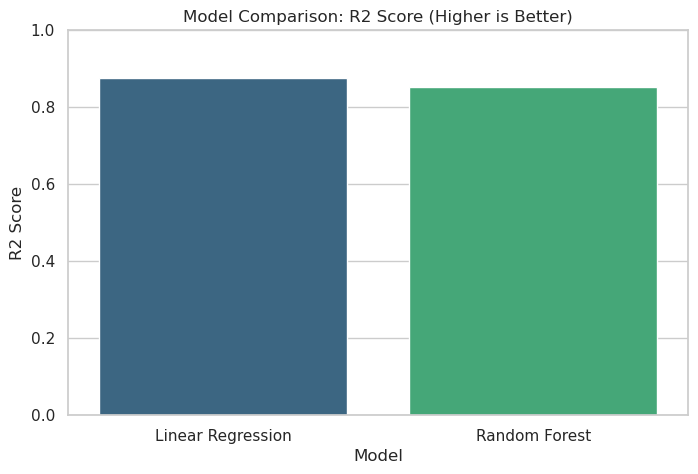

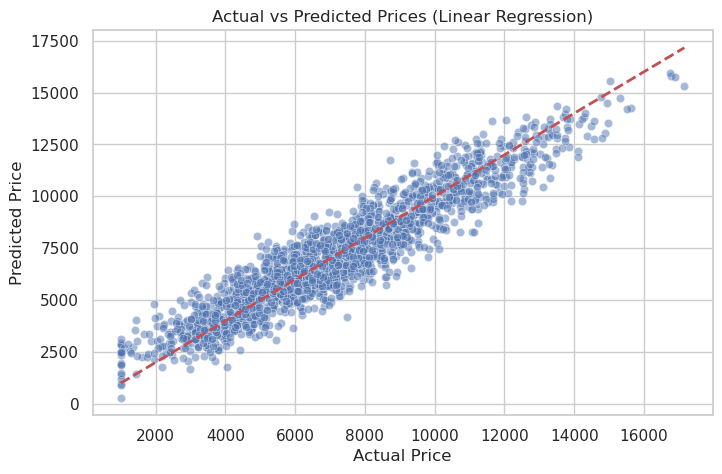

In [13]:
comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'R2 Score': [r2_lr, r2_rf],
    'RMSE': [rmse_lr, rmse_rf]
})

# Plot R2 Score Comparison
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='R2 Score', data=comparison, palette='viridis')
plt.title('Model Comparison: R2 Score (Higher is Better)')
plt.ylim(0, 1)
plt.show()

# Determine the best prediction to plot
if r2_rf > r2_lr:
    best_pred = y_pred_rf
    best_name = "Random Forest"
else:
    best_pred = y_pred_lr
    best_name = "Linear Regression"

# Plot Actual vs Predicted (Dynamic Best Model)
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=best_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) 
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title(f'Actual vs Predicted Prices ({best_name})') # Shows the name of the winner
plt.show()

### 7. Save Artifacts
We save the best performing model , the Scaler (essential for new data), and the Feature Names (to ensure correct column order in the app).

In [14]:
# Select best model
best_model = rf_model if r2_rf > r2_lr else lr_model
print(f"Saving best model: {best_model.__class__.__name__}")

# Save Model
joblib.dump(best_model, "../models/model.pkl")

# Save Scaler (Crucial for preprocessing user input in App)
joblib.dump(scaler, "../models/scaler.pkl")

# Save Feature Column Names (To align columns in App)
# NOTE: save the encoded/aligned training columns (X_train_enc),
# not the original X.columns — this ensures the app reindexes to the exact
# features the scaler and model expect.
joblib.dump(X_train_enc.columns.tolist(), "../models/features.pkl")

print("✅ All artifacts saved successfully to /models/")

Saving best model: LinearRegression
✅ All artifacts saved successfully to /models/
